# Starbucks Capstone Challenge - Data Exploration and Feature Engineering



# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [2]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline
import matplotlib.pyplot as plt

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [294]:
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)

## Exploring the Portfolio dataset

In [3]:
portfolio.head(5)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [12]:
portfolio.shape

(10, 6)

*Let's check missing values*

In [4]:
portfolio.isna().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

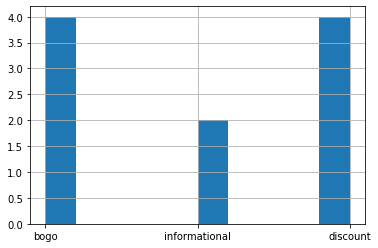

In [13]:
#what is the offer_type distribution
portfolio['offer_type'].hist()

### Details from the dataset

The unit of the columns **rewards** and **difficulty** is dollars, the name *difficulty* could be a bit confussing because it conveys the minimun value to be spent to complete the offer, and not how diificult is it to be completed.

There is no missing or negative values on these columns.

It is interesting that **discounts** offers are sent only by email and web, not by the mobile app.

## Exploring the profile dataset

In [269]:
profile.shape

(17000, 5)

In [270]:
profile.head(5)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [271]:
profile.isna().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

There are **2175** values missing in the gender and income columns, and it seems that age is **118** when those two column  values are missing. I will drop those records them from the dataset.

In [272]:
profile.dropna(inplace=True)
profile.shape

(14825, 5)

Lets see now the age distribution

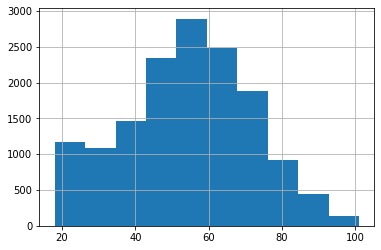

In [273]:
profile['age'].hist()

In [274]:
profile['age'].describe()

count    14825.000000
mean        54.393524
std         17.383705
min         18.000000
25%         42.000000
50%         55.000000
75%         66.000000
max        101.000000
Name: age, dtype: float64

In [275]:
profile.loc[profile['age']>66].shape[0]

3702

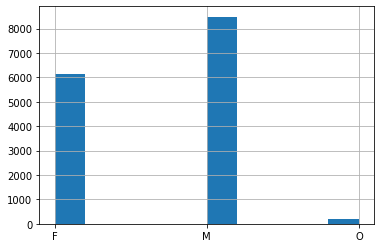

In [276]:
#Lets see now gender distribution
profile['gender'].hist()

In [277]:
profile['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

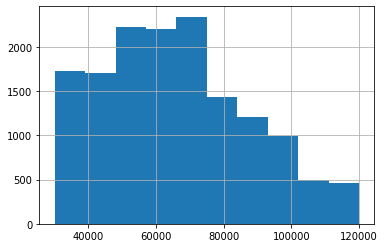

In [278]:
#Lets see now income distribution
profile['income'].hist()

In [279]:
#Lets see now gender distribution
profile['income'].describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

Text(0.5, 1.0, 'Other')

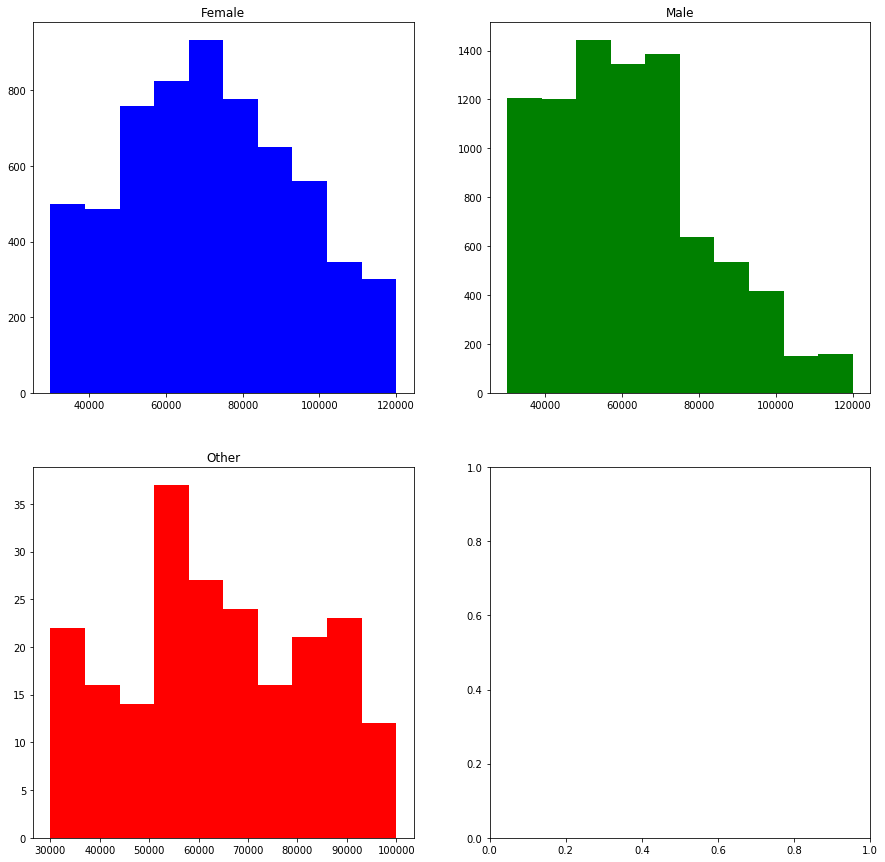

In [280]:
genders = profile['gender'].unique()
fig, axs = plt.subplots(2,2,figsize=(15,15))
colors = ['b','g','r']
axs[0,0].hist(profile.loc[profile['gender']=='F','income'],bins=10,histtype='bar',color=colors[0])
axs[0,0].set_title('Female')
axs[0,1].hist(profile.loc[profile['gender']=='M','income'],bins=10,histtype='bar',color=colors[1])
axs[0,1].set_title('Male')
axs[1,0].hist(profile.loc[profile['gender']=='O','income'],bins=10,histtype='bar',color=colors[2])
axs[1,0].set_title('Other')

In [281]:
genders = profile['gender'].unique()
for gender in genders:
    u = profile.loc[profile['gender']==gender,'income'].mean()
    print('{gender} Mean income is: {mean}'.format( gender=gender,mean=u))

F Mean income is: 71306.41213901126
M Mean income is: 61194.60160301744
O Mean income is: 63287.735849056604


Empirically we could think that income could be a relevant feature for the classification model we are trying to create, however a later formal analysis of the correlation of features of the model will give us the answer. For now it would be a good idea to create a new column where to have the income value scaled.

It is important to analyze the distribution of the **became_member_on** column as this can be an important feature within the model that defines a client and could help predict whether the offer will be completed or not. Before that it is necessary to process this column in order to use a more appropiate format.

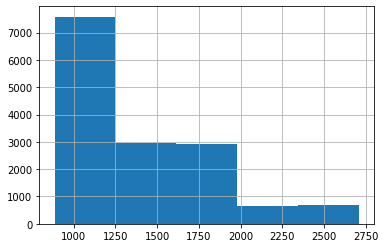

In [283]:
import datetime
from datetime import datetime as dt

profile['member_since'] = pd.to_datetime(profile['became_member_on'], format = '%Y%m%d')
profile['total_days_of_membership'] = (dt.today().date() - profile['member_since'].dt.date).dt.days
profile['total_days_of_membership'].hist(bins=5) 

In [284]:
profile['total_days_of_membership'].describe()

count    14825.000000
mean      1408.478988
std        419.205158
min        886.000000
25%       1094.000000
50%       1244.000000
75%       1683.000000
max       2709.000000
Name: total_days_of_membership, dtype: float64

According to the **total_days_of_membership** distribution, we can cluster this column in three categories 
   
    1     - 1093 days   :  0
    1094  - 1683 days   :  1
    > 1683              :  2

## Details from the dataset

The majority of clients are men (8484), followed by women (6129) and only 212 clients define their gender as other.

The average age of the clients is 54 years old. There are **3702** clients over 66 years old, which is **25%**.

The median income is 65400 dollars

Women's average income (71,306) is higher than men's (61,195) and than the average in the data set (65405)

The income range is from 30,000 to 120,000 

The average days of membership is 1408 days



In [248]:
transcript.shape

(306534, 4)

In [249]:
## Lers check for missing values
transcript.isna().sum()

person    0
event     0
value     0
time      0
dtype: int64

There is no missing values is the transcript dataset

In [250]:
transcript.head(5)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


The **value** columns is a dictionary, we need to know what keys are used.

In [251]:
#lets see what are the keys in transcript.value

for event_name in transcript['event'].unique():
    subset = transcript[transcript['event']==event_name]
    if (type (subset.iloc[0,2]) is dict ):
       print("{}  :  {}".format(event_name,subset.iloc[0,2].keys()))

offer received  :  dict_keys(['offer id'])
offer viewed  :  dict_keys(['offer id'])
transaction  :  dict_keys(['amount'])
offer completed  :  dict_keys(['offer_id', 'reward'])


And also see the distribution of events

In [252]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

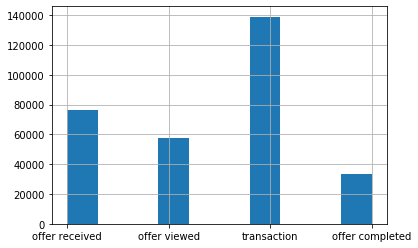

In [253]:
transcript['event'].hist()

In order to prepare the training dataset, a column will be added  to the transcript dataframe for each key that is in the Value column, we already know that they are (amount, reward, offer_id and offer id ) 

In [254]:
def determine_offerid_value(d):
    return d['offer_id'] if (d.get('offer_id') is not None) else d.get('offer id')

In [255]:
transcript.loc[:,'offer_id'] = transcript['value'].apply(lambda d: determine_offerid_value(d) if (type(d) is dict) else ' ')

In [256]:
transcript.loc[:,'amount'] = transcript[transcript['event']=='transaction']['value'].apply(lambda d: d['amount'])

In [257]:
transcript.loc[:,'reward'] = transcript[transcript['event']=='offer completed']['value'].apply(lambda d: d['reward'])

Let's see how the data looks for a specific client, we are going to eliminate the transaction type events, since we are interested in knowing the offers that were seen and then completed or not

In [258]:
transcript.loc[ (transcript['person'] == '78afa995795e4d85b5d9ceeca43f5fef') & (transcript['event']!='transaction'), ['person','event','offer_id','time'] ]

,person,event,offer_id,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,0
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,9b98b8c7a33c4b65b9aebfe6a799e6d9,6
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,9b98b8c7a33c4b65b9aebfe6a799e6d9,132
53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,5a8bc65990b245e5a138643cd4eb9837,168
85291,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,5a8bc65990b245e5a138643cd4eb9837,216
150598,78afa995795e4d85b5d9ceeca43f5fef,offer received,ae264e3637204a6fb9bb56bc8210ddfd,408
163375,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,ae264e3637204a6fb9bb56bc8210ddfd,408
201572,78afa995795e4d85b5d9ceeca43f5fef,offer received,f19421c1d4aa40978ebb69ca19b0e20d,504
218394,78afa995795e4d85b5d9ceeca43f5fef,offer completed,ae264e3637204a6fb9bb56bc8210ddfd,510
218395,78afa995795e4d85b5d9ceeca43f5fef,offer completed,f19421c1d4aa40978ebb69ca19b0e20d,510


In [259]:
transcript.loc[transcript['person'] == '78afa995795e4d85b5d9ceeca43f5fef'].groupby(['offer_id','event','time']).count()

person  value  amount  \
offer_id                         event           time                          
5a8bc65990b245e5a138643cd4eb9837 offer received  168        1      1       0   
                                 offer viewed    216        1      1       0   
9b98b8c7a33c4b65b9aebfe6a799e6d9 offer completed 132        1      1       0   
                                 offer received  0          1      1       0   
                                 offer viewed    6          1      1       0   
ae264e3637204a6fb9bb56bc8210ddfd offer completed 510        1      1       0   
                                 offer received  408        1      1       0   
                                 offer viewed    408        1      1       0   
f19421c1d4aa40978ebb69ca19b0e20d offer completed 510        1      1       0   
                                 offer received  504        1      1       0   
                                 offer viewed    582        1      1       0   

                                                       reward  
offer_id                         event           time          
5a8bc65990b245e5a138643cd4eb9837 offer received  168        0  
                                 offer viewed    216        0  
9b98b8c7a33c4b65b9aebfe6a799e6d9 offer completed 132        1  
                                 offer received  0          0  
                                 offer viewed    6          0  
ae264e3637204a6fb9bb56bc8210ddfd offer completed 510        1  
                                 offer received  408        0  
                                 offer viewed    408        0  
f19421c1d4aa40978ebb69ca19b0e20d offer completed 510        1  
                                 offer received  504        0  
                                 offer viewed    582        0

# Feature Engineering

First at all lets create a traning dataset

1 Merge transcript and profile

In [637]:
training_df = transcript.copy()

In [638]:
training_df.columns

Index(['person', 'event', 'value', 'time', 'offer_id', 'amount', 'reward'], dtype='object')

In [639]:
profile.columns

Index(['gender', 'age', 'person', 'became_member_on', 'income', 'std_income',
       'member_since', 'total_days_of_membership'],
      dtype='object')

In [640]:
profile =  profile.rename(columns={'id':'person'})
profile.set_index(['person'])

,gender,age,became_member_on,income,std_income,member_since,total_days_of_membership
person,,,,,,,
0610b486422d4921ae7d2bf64640c50b,F,55,20170715,112000.0,0.911111,2017-07-15,1262
78afa995795e4d85b5d9ceeca43f5fef,F,75,20170509,100000.0,0.777778,2017-05-09,1329
e2127556f4f64592b11af22de27a7932,M,68,20180426,70000.0,0.444444,2018-04-26,977
389bc3fa690240e798340f5a15918d5c,M,65,20180209,53000.0,0.255556,2018-02-09,1053
2eeac8d8feae4a8cad5a6af0499a211d,M,58,20171111,51000.0,0.233333,2017-11-11,1143
...,...,...,...,...,...,...,...
6d5f3a774f3d4714ab0c092238f3a1d7,F,45,20180604,54000.0,0.266667,2018-06-04,938
2cb4f97358b841b9a9773a7aa05a9d77,M,61,20180713,72000.0,0.466667,2018-07-13,899
01d26f638c274aa0b965d24cefe3183f,M,49,20170126,73000.0,0.477778,2017-01-26,1432


In [641]:
training_df   =  pd.merge( training_df , profile[['person','gender', 'age','total_days_of_membership','income']], 
                                                          on='person', how='right')
training_df = training_df.loc[training_df['event'].isin(['offer viewed','offer completed','offer received'])]


In [622]:
portfolio.columns

Index(['reward', 'channels', 'difficulty', 'duration', 'offer_type',
       'offer_id'],
      dtype='object')

In [642]:
portfolio =  portfolio.rename(columns={'id':'offer_id'})
portfolio.set_index(['offer_id'])

training_df   =  pd.merge( training_df , portfolio[['offer_id','reward', 'difficulty','duration', 'offer_type']], 
                                                          on='offer_id', how='left')



In [643]:
training_df['completed'] = 0.0
training_df=training_df.drop(columns=['value','amount','reward_x'])
training_df =  training_df.rename(columns={'reward_y':'reward'})

In [625]:
#The objective of this function is to mark the offers received that were successfully completed
def determine_offer_completed(person,offer_id,time):  
    
    result = training_df.loc[  (training_df['person']   == person) 
                               & (training_df['offer_id'] == offer_id) 
                               & (training_df['time']>time), ['event','time']
                             ].sort_values(['time'],ascending=True).head(2)['event']   
  
    completed = (len(result)==2) and (result.iloc[[0][0]]=='offer viewed') and (result.iloc[[1][0]]=='offer completed')
    return (1.0 if completed else 0.0)



In [628]:
#we will process all the offers received to determine whether or not they were successfully completed

training_df['completed'] = ( training_df.loc[training_df['event']=='offer received']
                            .apply(lambda x: determine_offer_completed(x.person, x.offer_id, x.time), axis=1) )
training_df.fillna(0.0, inplace = True)


In [644]:
total_completed = len(training_df.loc[ (training_df['event']=='offer received') & (training_df['completed']==1.0) ])
percentage_completed = (total_completed / len(training_df.loc[ (training_df['event']=='offer received')])) * 100
print('Total offers completed {total}'.format(total=total_completed))
print('Percentage offers Completed {total}'.format(total=percentage_completed))


Total offers completed 0
Percentage offers Completed 0.0


## Feature engineering to do

    Merge training dataset with portfolio
    scale income
    scale age
    one hot encode offer_type
    one hot encode gender
    create categories for total_days_of_membership    
    remove person id
    remove offer id


In [645]:
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder


scaler = preprocessing.MinMaxScaler()
training_df['std_income'] = scaler.fit_transform(training_df[['income']])
training_df['std_age'] = scaler.fit_transform(training_df[['age']])

#one hot encode offer_type
enc = OneHotEncoder(handle_unknown='ignore')
enc_offer = pd.DataFrame(enc.fit_transform(  pd.DataFrame(training_df['offer_type'])  ).toarray())

feature_labels = enc.categories_
feature_labels = np.array(feature_labels).ravel()
enc_offer.columns = feature_labels

#one hot encode gender
enc_gender = pd.DataFrame(enc.fit_transform(pd.DataFrame(training_df['gender'])).toarray())

feature_labels = enc_g.categories_
feature_labels = np.array(feature_labels).ravel()
enc_gender.columns = feature_labels


In [646]:
training_df = training_df.join(enc_offer)
training_df = training_df.join(enc_gender)
training_df.head(100)

,person,event,time,offer_id,gender,age,total_days_of_membership,income,reward,difficulty,...,offer_type,completed,std_income,std_age,bogo,discount,informational,F,M,O
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,1329,100000.0,5,5,...,bogo,0.0,0.777778,0.686747,1.0,0.0,0.0,1.0,0.0,0.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,1329,100000.0,5,5,...,bogo,0.0,0.777778,0.686747,1.0,0.0,0.0,1.0,0.0,0.0
2,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,1329,100000.0,5,5,...,bogo,0.0,0.777778,0.686747,1.0,0.0,0.0,1.0,0.0,0.0
3,78afa995795e4d85b5d9ceeca43f5fef,offer received,168,5a8bc65990b245e5a138643cd4eb9837,F,75,1329,100000.0,0,0,...,informational,0.0,0.777778,0.686747,0.0,0.0,1.0,1.0,0.0,0.0
4,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,216,5a8bc65990b245e5a138643cd4eb9837,F,75,1329,100000.0,0,0,...,informational,0.0,0.777778,0.686747,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,c27e0d6ab72c455a8bb66d980963de60,offer viewed,618,5a8bc65990b245e5a138643cd4eb9837,F,78,1291,71000.0,0,0,...,informational,0.0,0.455556,0.722892,0.0,0.0,1.0,1.0,0.0,0.0
96,d53717f5400c4e84affdaeda9dd926b3,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,F,88,1320,53000.0,5,20,...,discount,0.0,0.255556,0.843373,0.0,1.0,0.0,1.0,0.0,0.0
97,d53717f5400c4e84affdaeda9dd926b3,offer viewed,30,0b1e1539f2cc45b7b9fa7c272da2e1d7,F,88,1320,53000.0,5,20,...,discount,0.0,0.255556,0.843373,0.0,1.0,0.0,1.0,0.0,0.0
98,d53717f5400c4e84affdaeda9dd926b3,offer completed,30,0b1e1539f2cc45b7b9fa7c272da2e1d7,F,88,1320,53000.0,5,20,...,discount,0.0,0.255556,0.843373,0.0,1.0,0.0,1.0,0.0,0.0


Lets create categories for the column **total_days_of_membership**

    1     - 1093 days   :  0
    1094  - 1683 days   :  1
    > 1683              :  2

In [660]:
def categorize_tot_days_membership(days):
    if days in range (1,1093):
        return 0
    elif days in range (1094,1683):
        return 1
    else:
        return 2
        
training_df['type_of_membership'] =  training_df['total_days_of_membership'].apply(lambda x: categorize_tot_days_membership(x))  

In [662]:
#training_df=training_df.drop(columns=['person', 'event', 'offer_id', 'gender', 'age', 'income','offer_type','total_days_of_membership'] )
training_df

,time,total_days_of_membership,reward,difficulty,duration,completed,std_income,std_age,bogo,discount,informational,F,M,O,type_of_membership
0,0,1329,5,5,7,0.0,0.777778,0.686747,1.0,0.0,0.0,1.0,0.0,0.0,1
1,6,1329,5,5,7,0.0,0.777778,0.686747,1.0,0.0,0.0,1.0,0.0,0.0,1
2,132,1329,5,5,7,0.0,0.777778,0.686747,1.0,0.0,0.0,1.0,0.0,0.0,1
3,168,1329,0,0,3,0.0,0.777778,0.686747,0.0,0.0,1.0,1.0,0.0,0.0,1
4,216,1329,0,0,3,0.0,0.777778,0.686747,0.0,0.0,1.0,1.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148800,504,1172,0,0,4,0.0,0.711111,0.349398,0.0,0.0,1.0,0.0,1.0,0.0,1
148801,576,1172,10,10,5,0.0,0.711111,0.349398,1.0,0.0,0.0,0.0,1.0,0.0,1
148802,576,1172,10,10,5,0.0,0.711111,0.349398,1.0,0.0,0.0,0.0,1.0,0.0,1
148803,576,1530,10,10,5,0.0,0.533333,0.481928,1.0,0.0,0.0,1.0,0.0,0.0,1


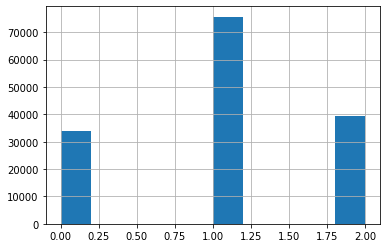

In [661]:
training_df['type_of_membership'].hist()